In [1]:
%matplotlib inline
from skimage import io
from skimage.color import rgb2gray
from matplotlib import pyplot as plt, colors
from glob import glob
from skimage.filters import sobel
import numpy as np
from itertools import product
import skimage.morphology as mp
from skimage import measure
from skimage.measure import find_contours as fc
from skimage import feature
from skimage import img_as_float

In [2]:
def collage(data, n=6, m=3, width=12, imparams={}):
    sh = data[0].shape
    ratio = sh[0]/sh[1] * n/m
    fig, axes = plt.subplots(n, m,
                             gridspec_kw={"wspace": 0, "hspace": 0})
    fig.set_size_inches(width, width*ratio)
    axes = axes.flatten()
    for i, img in enumerate(data):
        axes[i].axis("off")
        axes[i].imshow(img, aspect='auto', **imparams)
    plt.show()

In [3]:
planes_orig = [io.imread(fn) for fn in sorted(glob("data/samolot??.jpg"))]
planes_bw = [rgb2gray(p) for p in planes_orig]

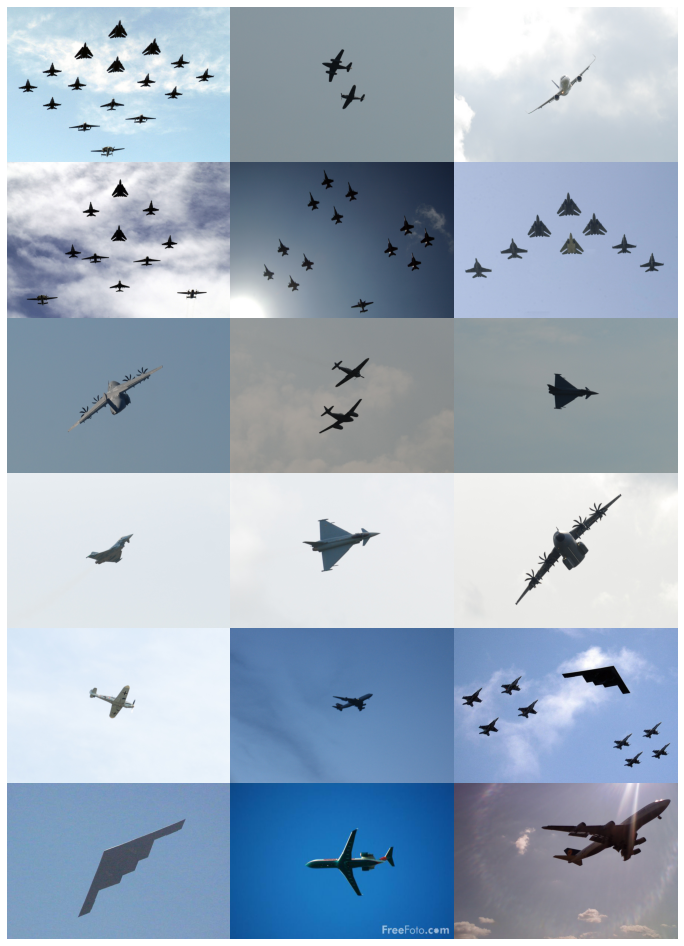

In [4]:
collage(planes_orig)

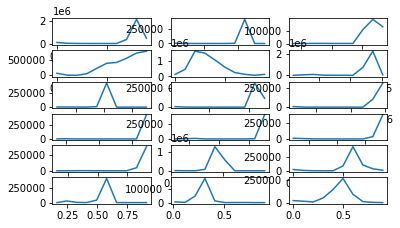

In [6]:
def hist(img, ax=plt, **kwargs):
    h, x = np.histogram(img)
    ax.plot(x[:-1], h, **kwargs)

for i, p in enumerate(planes_bw):
    plt.subplot(7, 3, i+1)
    hist(p)

In [7]:
sh = planes_orig[0].shape
ar = sh[0] / sh[1]

In [14]:
### Helper functions for grouping contours belonging to the same plane

def bbox(c):
    diag = *np.min(c, 0), *np.max(c, 0)
    return list(product(diag[::2], diag[1::2]))

def bboxwh(bb):
    return bb[3][0]-bb[0][0], bb[3][1]-bb[0][1]

def in_bbox(p, diag, sl=0):
    return diag[0][0]-sl < p[0] < diag[1][0]+sl and \
            diag[0][1]-sl < p[1] < diag[1][1]+sl

def bboxr(bb):
    return min(bboxwh(bb))/2
def bboxcr(bb):
    r = bboxr(bb)
    ctr = ((bb[0][0]+bb[3][0])/2, (bb[0][1]+bb[3][1])/2)
    return ctr, r

# slack as percent
def circ_int(bb1, bb2, slp=0):
    c1, r1 = bboxcr(bb1)
    c2, r2 = bboxcr(bb2)
    sl = max(r1, r2)*slp
    return (c2[0]-c1[0])**2+(c2[1]-c1[1])**2 < (r1+r2+sl)**2

def intersect(bb1, bb2, slack=0):
    d1 = [bb1[0], bb1[3]]
    d2 = [bb2[0], bb2[3]]
    return any(in_bbox(p, d2, slack) for p in bb1) or \
            any(in_bbox(p, d1, slack) for p in bb2)


In [17]:
from matplotlib import patches
from random import random as rr
pc = 0

def draw_contour(bw_pic, col_pic, ax=plt):
    
    pp = bw_pic.copy()
    
    if (pp.std() <= 0.05):
        MIN = pp.mean() - pp.std()
        MAX = pp.mean() + pp.std()
        norm = (pp - MIN) / (MAX - MIN)
        norm[norm > 1] = 1
        norm[norm < 0] = 0
        pp = norm
        
    pp = pp.clip(0, np.percentile(pp, 70))

    
    pp = feature.canny(pp, sigma=3)
    pp = (pp > 0.7)*1.0
    
    pp = mp.dilation(pp)
    


    
    ax.imshow(pp, cmap='gray', aspect='auto') if col_pic is None else ax.imshow(col_pic, aspect='auto')
    
    
    slack = 0.4
    
    # contours descending by size
    cs = fc(pp, level=0.8)
    cs.sort(key=lambda x:bboxr(bbox(x)), reverse=True)

    cs2 = []
    bboxes = []
    for j, c in enumerate(cs):
        bb = bbox(c)
            
        for i, (c1, bb1) in enumerate(zip(cs2, bboxes)):
            if circ_int(bb, bb1, slack) or intersect(bb, bb1, 0):
                c1 = cs2[i] = np.append(c1, c, 0)
                bboxes[i] = bbox(cs2[i])
                break
        else:
            cs2.append(c)
            bboxes.append(bbox(c))
            
    last_h = 0
    for c in cs2:
        ctr = np.mean(c, 0)
        hsv = (last_h, 1, 1)
        last_h = (last_h+0.15)%1
        col = [[*colors.hsv_to_rgb(hsv)]]
        ax.scatter(c[:,1], c[:,0], [0.5]*len(c), c=col)
        ax.scatter([ctr[1]], [ctr[0]], c='w')

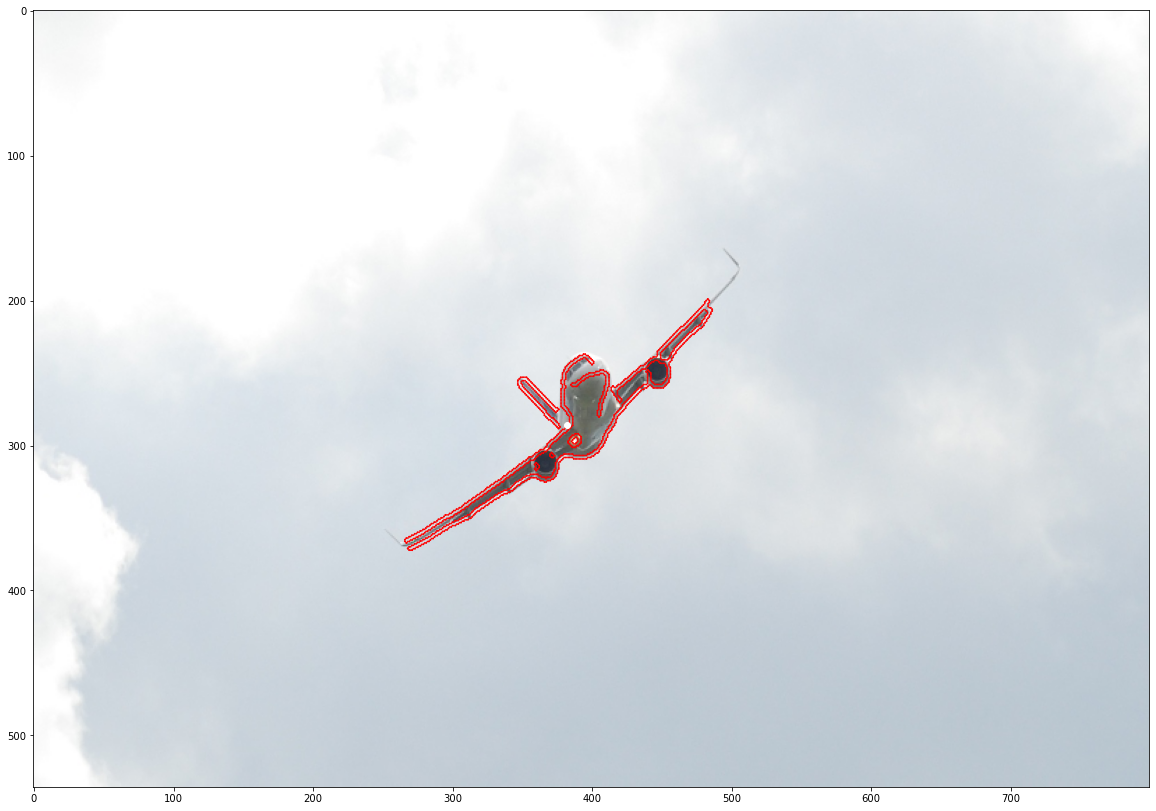

In [15]:
pi = 2
fw = 20
fig, ax = plt.subplots()
fig.set_size_inches((fw, fw*ar))
draw_contour(planes_bw[pi], planes_orig[pi], ax)

In [11]:
def collage2(data_gen, n=6, m=3, width=12, imparams={}, nplanes=None):
    global pc
    fig, axes = plt.subplots(n, m,
                             gridspec_kw={"wspace": 0, "hspace": 0})
    fig.set_size_inches(width, width*ar*n/m)
    axes = axes.flatten()
    if nplanes is None: nplanes = n*m
    for i in range(nplanes):
        print("{}/{}".format(i+1, nplanes))
        axes[i].axis("off")
        data_gen(i, axes[i])
    plt.show()

In [12]:
def planes_gen(i, ax):
    draw_contour(planes_bw[i], planes_orig[i], ax)


1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
18/18


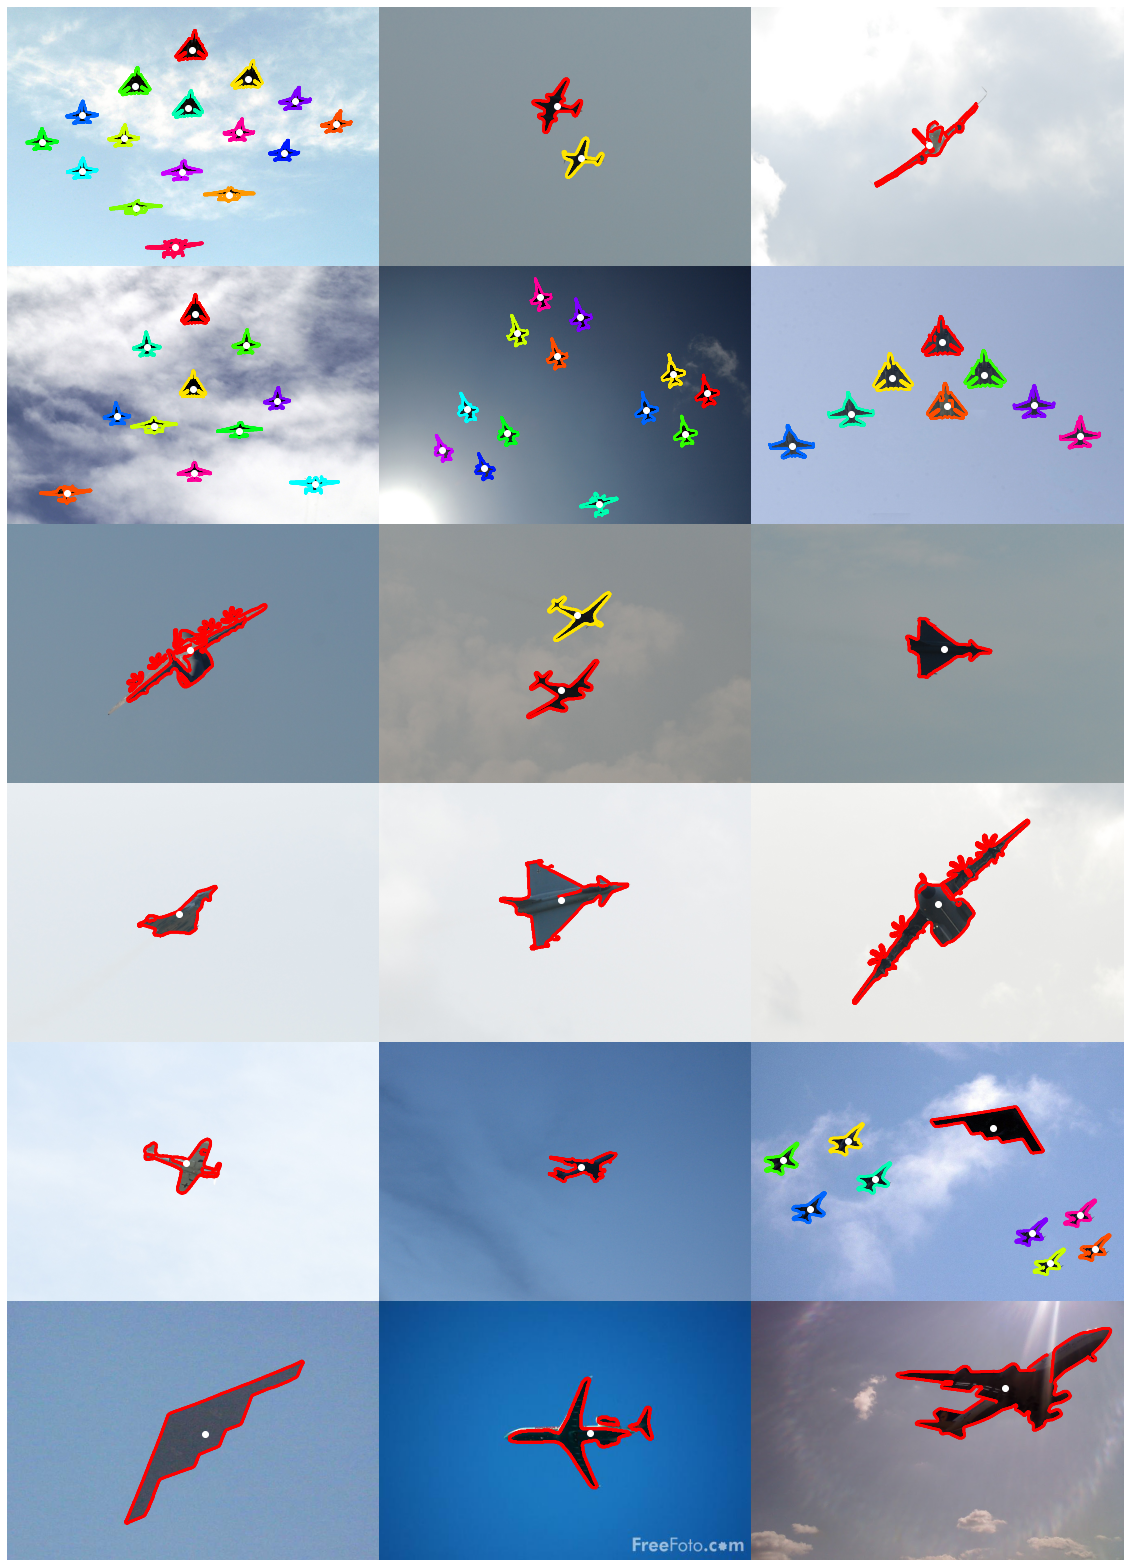

In [16]:
collage2(planes_gen, 6, width=20)